**Course Project**

*Topic*: Fake News Detection

*Written by*: Andrii Shchur & Bohdana Honserovska

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


For this project we are using a dataset from Kaggle: https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification

In [2]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/fake_news.csv')

Let's take a look at dataset we currently have

In [3]:
df

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
...,...,...,...,...
72129,72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0
72130,72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1
72131,72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0
72132,72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0


Let's get info to handle NaN values

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


We have NaN values in `titles` and `text`, so we will fill them with empty strings.

In [5]:
df['text'].fillna('', inplace=True)
df['title'].fillna('', inplace=True)

Also we need to make `label` categorical

In [6]:
df['label'] = df['label'].astype('category')

Let's concatenate columns `title` and `text` to reduce number of features, because these 2 columns reproduce similar values.

In [7]:
df['text'] = df['title'] + ' ' + df['text']

We don't need title now, because it is already concatenated in text column

In [8]:
df.drop(['title'], axis=1, inplace=True)

Now, we will lowercase all the symbols. For example, this way our model won't classify words "president" and "President" as 2 different words, but as one.

In [9]:
df.loc[:, 'text'] = df.text.apply(lambda x: x.lower())

Now we should get rid of all digits and punctuation marks.

In [10]:
df.loc[:, 'text'] = df.text.str.replace('[^\s\w]|[\d]', '')

<ipython-input-10-ededb98f9bc9>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df.loc[:, 'text'] = df.text.str.replace('[^\s\w]|[\d]', '')


We need to avoid stop words. Stop words are a set of commonly used words in any language. They don't have an impact on the context. Mostly these are articles, prepositions, and conjunctions. For example, such words might be 'a', 'the', 'to', 'how', 'what', 'in', 'than', 'and' etc.

In [11]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

With the use of Natural Language Toolkit we'll skip these stopwords

In [12]:
sw = set(stopwords.words('english')) 
df.loc[:, 'text'] = df.text.apply(
    lambda x: ' '.join(word for word in x.split() if word not in sw)
)

So we've already done some preprocessing, let's look at what we have now

In [13]:
df

,Unnamed: 0,text,label
0,0,law enforcement high alert following threats c...,1
1,1,post votes hillary already,1
2,2,unbelievable obamas attorney general says char...,1
3,3,bobby jindal raised hindu uses story christian...,0
4,4,satan russia unvelis image terrifying new supe...,1
...,...,...,...
72129,72129,russians steal research trump hack us democrat...,0
72130,72130,watch giuliani demands democrats apologize tru...,1
72131,72131,migrants refuse leave train refugee camp hunga...,0
72132,72132,trump tussle gives unpopular mexican leader mu...,0


Also, we often face the same word in different forms. So instead of having only a word 'visit', we can have 'visit', 'visiting', and 'visited', which mean all the same. Let's convert it into one form.

In [14]:
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')

lemma = WordNetLemmatizer()
df.loc[:, 'text'] = df.text.apply(
    lambda x: ' '.join(lemma.lemmatize(word) for word in x.split())
)

[nltk_data] Downloading package wordnet to /root/nltk_data...


After all preprocessing with words is done, we need to interpret it as integers. Firstly, we need to know the length of our vocabulary. 

In [15]:
unique_words = set()

for row in df['text']:
    words = row.split()
    
    unique_words.update(words)

vocab_size = len(unique_words)
print(f'The size of the vocabulary is {vocab_size}')

The size of the vocabulary is 348032


Of course, it's too big to remember all of them. If we remember all, we'll need to train our model for hours, maybe days. So we'll reduce it and do one_hot encoding.

In [16]:
from tensorflow.keras.preprocessing.text import one_hot

one_hot_n = 10000
one_hot_text = df['text'].apply(lambda x: one_hot(x, one_hot_n))

But model needs arrays with equal length. Each text has unique length, we need to find some value. Smaller texts will be filled with zeros in the end of the array, bigger will be cut.

In [17]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

pad_length = 200
X = np.array(pad_sequences(one_hot_text, maxlen=pad_length))
y = np.array(df['label'])

Once all the data is ready, we can start developing our model. Here you can view function for tracking training of the models. Every epoch we'll get new plot with previous epochs with training and validation loss and accuracy.

In [18]:
import matplotlib.pyplot as plt
from keras.callbacks import Callback


class TrainingHistory(Callback):
    def on_train_begin(self, logs={}):
        self.loss = []
        self.val_loss = []
        self.acc = []
        self.val_acc = []

    def on_epoch_end(self, epoch, logs={}):
        self.loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

        plt.clf()
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

        ax1.plot(self.loss, 'b', label='Training Loss')
        ax1.plot(self.val_loss, 'r', label='Validation Loss')
        ax1.set_ylabel('Loss')
        ax1.legend(loc='best')

        ax2.plot(self.acc, 'b', label='Training Accuracy')
        ax2.plot(self.val_acc, 'r', label='Validation Accuracy')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.legend(loc='best')

        plt.show()

history = TrainingHistory()

We can start building our model's architecture.

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2

vector_features = 64
model = Sequential([
    Embedding(one_hot_n, vector_features, input_length=pad_length),
    LSTM(vector_features, recurrent_dropout=0.2, dropout=0.8, kernel_regularizer=l2(0.01)),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid'),
])
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

Here you can see the summary of our model, its layers, shapes and number of parameters.

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 64)           640000    
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 674,081
Trainable params: 674,081
Non-trainable params: 0
_________________________________________________________________


Now we'll train our model. Also we add early stopping to prevent overfitting.

Epoch 1/10
902/902 [==============================] - ETA: 0s - loss: 0.9839 - accuracy: 0.7429

<Figure size 640x480 with 0 Axes>

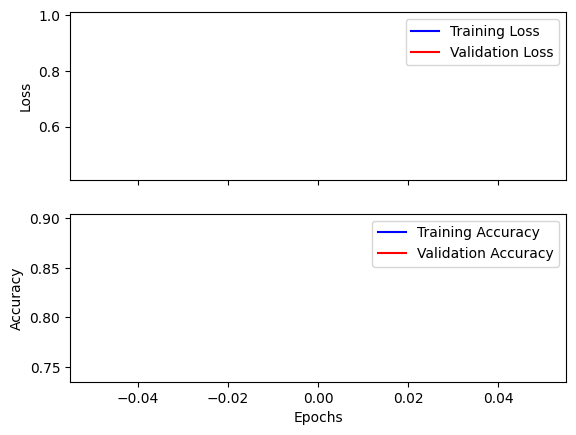

902/902 [==============================] - 950s 1s/step - loss: 0.9839 - accuracy: 0.7429 - val_loss: 0.4352 - val_accuracy: 0.8968
Epoch 2/10
902/902 [==============================] - ETA: 0s - loss: 0.3774 - accuracy: 0.8970

<Figure size 640x480 with 0 Axes>

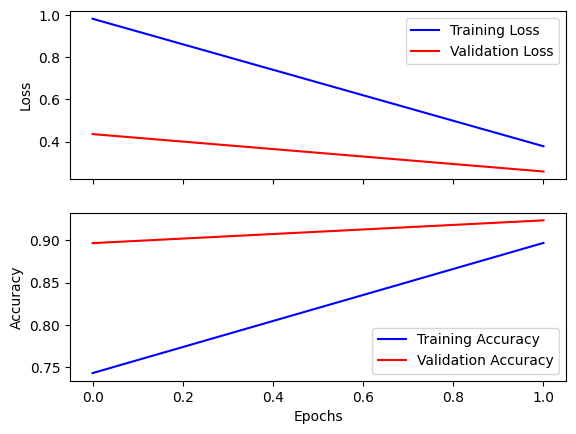

902/902 [==============================] - 848s 940ms/step - loss: 0.3774 - accuracy: 0.8970 - val_loss: 0.2574 - val_accuracy: 0.9238
Epoch 3/10
902/902 [==============================] - ETA: 0s - loss: 0.2708 - accuracy: 0.9185

<Figure size 640x480 with 0 Axes>

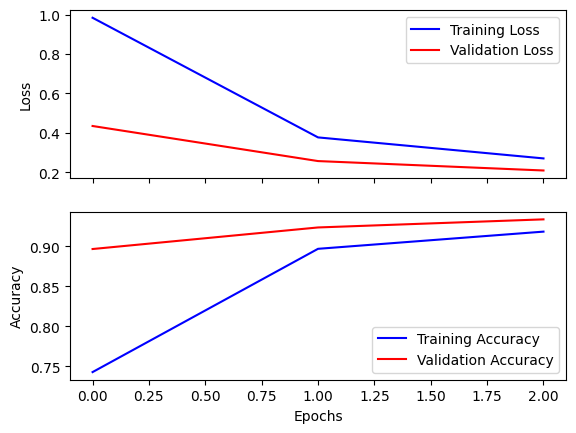

902/902 [==============================] - 852s 945ms/step - loss: 0.2708 - accuracy: 0.9185 - val_loss: 0.2097 - val_accuracy: 0.9339
Epoch 4/10
902/902 [==============================] - ETA: 0s - loss: 0.2297 - accuracy: 0.9288

<Figure size 640x480 with 0 Axes>

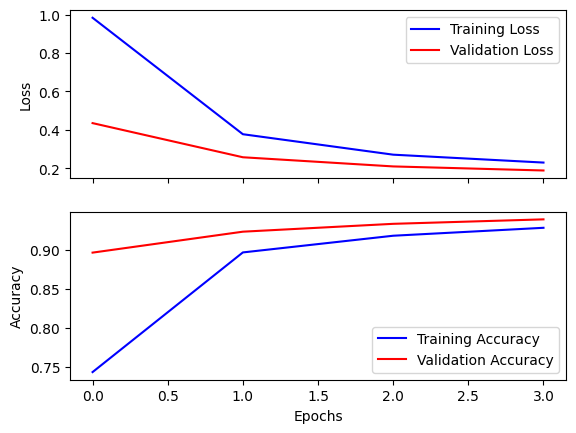

902/902 [==============================] - 830s 920ms/step - loss: 0.2297 - accuracy: 0.9288 - val_loss: 0.1885 - val_accuracy: 0.9396
Epoch 5/10
902/902 [==============================] - ETA: 0s - loss: 0.2110 - accuracy: 0.9353

<Figure size 640x480 with 0 Axes>

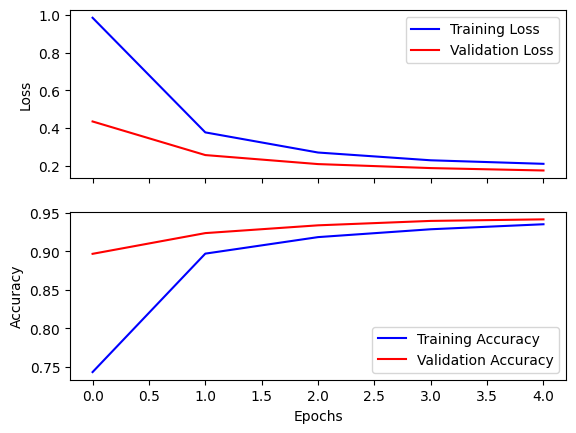

902/902 [==============================] - 832s 921ms/step - loss: 0.2110 - accuracy: 0.9353 - val_loss: 0.1758 - val_accuracy: 0.9416
Epoch 6/10
902/902 [==============================] - ETA: 0s - loss: 0.1942 - accuracy: 0.9391

<Figure size 640x480 with 0 Axes>

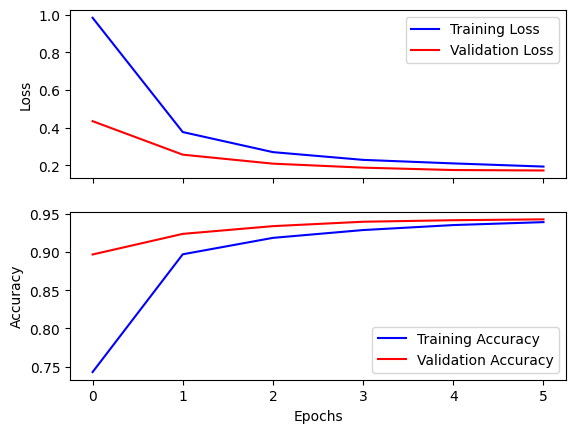

902/902 [==============================] - 831s 921ms/step - loss: 0.1942 - accuracy: 0.9391 - val_loss: 0.1734 - val_accuracy: 0.9427
Epoch 7/10
902/902 [==============================] - ETA: 0s - loss: 0.1828 - accuracy: 0.9430

<Figure size 640x480 with 0 Axes>

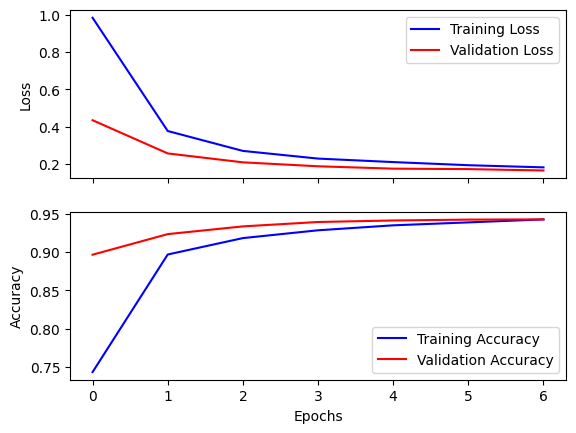

902/902 [==============================] - 853s 946ms/step - loss: 0.1828 - accuracy: 0.9430 - val_loss: 0.1660 - val_accuracy: 0.9431
Epoch 8/10
902/902 [==============================] - ETA: 0s - loss: 0.1737 - accuracy: 0.9459

<Figure size 640x480 with 0 Axes>

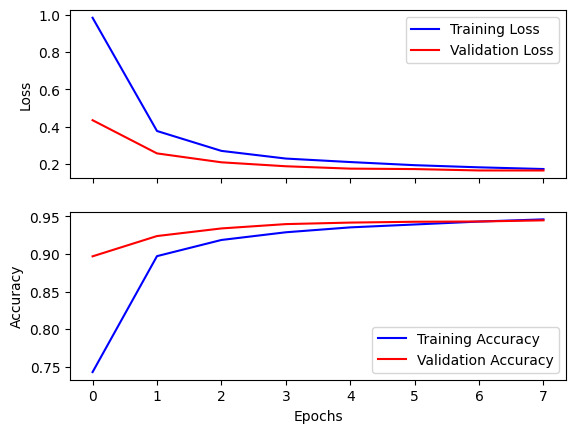

902/902 [==============================] - 853s 946ms/step - loss: 0.1737 - accuracy: 0.9459 - val_loss: 0.1658 - val_accuracy: 0.9446
Epoch 9/10
902/902 [==============================] - ETA: 0s - loss: 0.1656 - accuracy: 0.9485

<Figure size 640x480 with 0 Axes>

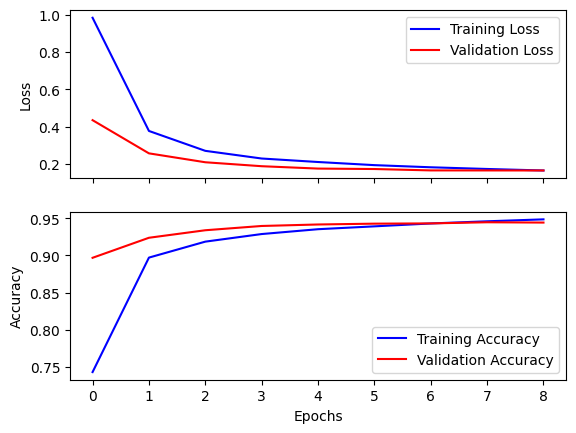

902/902 [==============================] - 851s 944ms/step - loss: 0.1656 - accuracy: 0.9485 - val_loss: 0.1656 - val_accuracy: 0.9442
Epoch 10/10
902/902 [==============================] - ETA: 0s - loss: 0.1580 - accuracy: 0.9506

<Figure size 640x480 with 0 Axes>

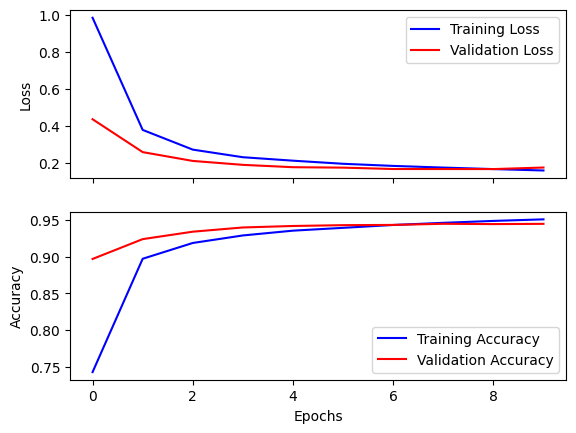

Restoring model weights from the end of the best epoch: 8.
902/902 [==============================] - 839s 930ms/step - loss: 0.1580 - accuracy: 0.9506 - val_loss: 0.1740 - val_accuracy: 0.9445
Epoch 10: early stopping


In [21]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', 
                               patience=2, 
                               restore_best_weights=True,
                               verbose=1)

model.fit(X, y, validation_split=0.2, epochs=10, batch_size=64, callbacks=[history, early_stopping])

Save the model to use it in our project.

In [22]:
model.save('/content/drive/MyDrive/model')

# Testing
Now we will test our model using other [dataset](https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset)

Let's write function that makes all the preprocessing stuff

In [23]:
def text_to_input(text_arr, one_hot_n, pad_length):
    text_arr = text_arr.apply(lambda x: x.lower())
    text_arr = text_arr.str.replace('[^\s\w]|[\d]', '')
    text_arr = text_arr.apply(
        lambda x: ' '.join(word for word in x.split() if word not in sw)
    )
    text_arr = text_arr.apply(
        lambda x: ' '.join(lemma.lemmatize(word) for word in x.split())
    )

    one_hot_text = [one_hot(text, one_hot_n) for text in text_arr]
    res = np.array(pad_sequences(one_hot_text, padding='pre', maxlen=pad_length)) 
    return res

Read both datasets with true and fake values

In [24]:
fake_dataset = pd.read_csv('/content/drive/MyDrive/Fake.csv')
true_dataset = pd.read_csv('/content/drive/MyDrive/True.csv')
fake_dataset['text'] = fake_dataset['title'] + ' ' + fake_dataset['text']
true_dataset['text'] = true_dataset['title'] + ' ' + true_dataset['text']

Take only title and text concatenated columns

In [25]:
articles_fake = fake_dataset.loc[:, 'text']
articles_true = true_dataset.loc[:, 'text']

Call function and predict values

In [26]:
X_test_fake = text_to_input(articles_fake, one_hot_n, pad_length)
X_test_true = text_to_input(articles_true, one_hot_n, pad_length)
result_fake = model.predict(X_test_fake)
result_fake = result_fake.flatten()
result_true = model.predict(X_test_true)
result_true = result_true.flatten()

<ipython-input-23-55fe2b233c79>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  text_arr = text_arr.str.replace('[^\s\w]|[\d]', '')


670/670 [==============================] - 40s 60ms/step


Plot results using histogram to compare amount

(array([  767., 22714.]),
 array([4.48683277e-04, 5.00220597e-01, 9.99992490e-01]),
 <BarContainer object of 2 artists>)

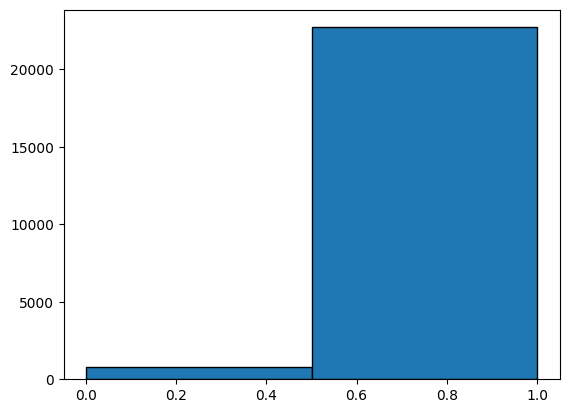

In [27]:
plt.hist(result_fake, bins=2, edgecolor='black')

(array([21310.,   107.]),
 array([3.97594789e-07, 4.99347925e-01, 9.98695433e-01]),
 <BarContainer object of 2 artists>)

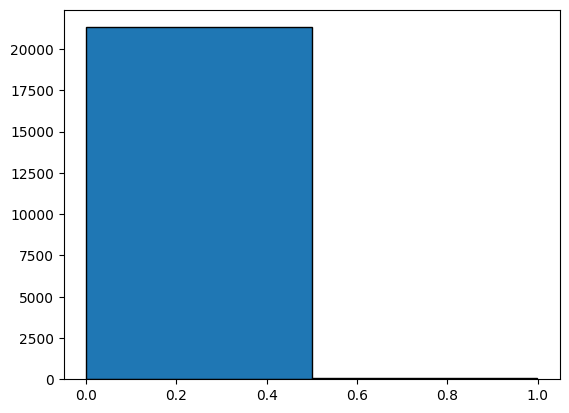

In [28]:
plt.hist(result_true, bins=2, edgecolor='black')